In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

In [2]:
pres_file = 'data/1976-2016-president.csv'
house_file = 'data/1976-2016-house.csv'
senate_file = 'data/1976-2016-senate.csv'

pres_df = pd.read_csv(pres_file, usecols=["year", "state_po", "party", "candidatevotes"])
house_df = pd.read_csv(house_file, usecols=["year", "state_po", "district", "party", "candidatevotes"])
senate_df = pd.read_csv(senate_file, usecols=["year", "state_po", "party", "candidatevotes"])
cols = list(pres_df)
cols.append('totalvotes')
cols.append('election')
print(cols)

['year', 'state_po', 'party', 'candidatevotes', 'totalvotes', 'election']


In [3]:
pres_df = pres_df[(pres_df.party == 'democrat') | (pres_df.party == 'republican')]
house_df = house_df[(house_df.party == 'democrat') | (house_df.party == 'republican')]
senate_df = senate_df[(senate_df.party == 'democrat') | (senate_df.party == 'republican')]

In [4]:
class State_Model:
    def __init__(self, state_abbr, state_pres_data, state_senate_data, state_house_data):
        self.state = state_abbr
        
        self.__distill(state_pres_data, state_senate_data, state_house_data)
        
    def __distill(self, pres_data, senate_data, house_data):
        cols = list(pres_data)
        cols.append('totalvotes')
        cols.append('election')
        df = pd.DataFrame(columns=cols)
        
        pres_years = pres_data.year.unique()
        senate_years = senate_data.year.unique()
        house_years = house_data.year.unique()
        
        pres_total_votes = pres_data.groupby(['year']).candidatevotes.sum()
        senate_total_votes = senate_data.groupby(['year']).candidatevotes.sum()
        house_party_votes = house_data.groupby(['year', 'party']).candidatevotes.sum()
        house_total_votes = house_data.groupby('year').candidatevotes.sum()        
        
        for year in range(1976, 2018, 2):
            if year in pres_years:
                py = year
            else:
                if len(pres_years[pres_years < year]) < 1:
                    py = int(pres_years[pres_years > year].min())
                else:
                    py = int(pres_years[pres_years < year].max())
            
            if year in senate_years:
                sy = year
            else:
                if len(senate_years[senate_years < year]) < 1:
                    sy = int(senate_years[senate_years > year].min())
                else:
                    sy = int(senate_years[senate_years < year].max())

            if year in house_years:
                hy = year
            else:
                if len(house_years[house_years < year]) < 1:
                    hy = int(house_years[house_years > year].min())
                else:
                    hy = int(house_years[house_years < year].max())


            for party in ['republican', 'democrat']:
                #pres
                df = df.append({'year' : year, 'state_po' : self.state,
                                'party' : party,
                                'candidatevotes' : pres_data[(pres_data.year == py) & (pres_data.party == party)].candidatevotes.sum(),
                                'totalvotes' : pres_total_votes[py],
                                'election' : 'pres'
                               }, ignore_index=True)
            
                #senate
                df = df.append({'year' : year, 'state_po' : self.state,
                                'party' : party,
                                'candidatevotes' : senate_data[(senate_data.year == sy) & (senate_data.party == party)].candidatevotes.sum(),
                                'totalvotes' : senate_total_votes[sy],
                                'election' : 'senate'
                               }, ignore_index=True)

                #house
                try:
                    df = df.append({'year' : year, 'state_po' : self.state,
                                    'party' : party,
                                    'candidatevotes' : house_party_votes[hy][party],
                                    'totalvotes' : house_total_votes[hy],
                                    'election' : 'house'
                                   }, ignore_index=True)
                except:
                    df = df.append({'year' : year, 'state_po' : self.state,
                                    'party' : party,
                                    'candidatevotes' : 0,
                                    'totalvotes' : house_total_votes[hy],
                                    'election' : 'house'
                                   }, ignore_index=True)
                    pass
                    
        
        df['vote_pct'] = df['candidatevotes']/df['totalvotes']
        
        self.dems = df[(df.party == 'democrat')]
        self.reps = df[(df.party == 'republican')]
    
    def average(self):
        dems = self.dems[self.dems.year < 2016]
        reps = self.reps[self.reps.year < 2016]
        dem_mean = dems['vote_pct'].mean(axis=0)
        rep_mean = reps['vote_pct'].mean(axis=0)
        
        return({'democrat' : dem_mean, 'republican': rep_mean})
    
    def weighted_average(self):
        # for weighted average, calculate weight based on date: 1 - (2018-yr)*decay
        # rework weights to get them all positive
        # pres_decay = 5./121
        # pres_dems['weight'] = 1 - (2018. - pres_dems['year'])*pres_decay
        # pres_reps['weight'] = 1 - (2018. - pres_reps['year'])*pres_decay        
        # congress_decay = 115./231
        # senate_data['weight'] = 1 - (2018. - senate_data['year'])*congress_decay
        # house_data['weight'] = 1 - (2018. - house_data['year'])*congress_decay
        
        dems = self.dems[self.dems.year < 2016]
        reps = self.reps[self.reps.year < 2016]
        
        #not including 2016 because we test on 2018
        decay = 0.1/3
        
        dems['weight'] = decay * (dems['year'] - 1974.)/42
        reps['weight'] = decay * (reps['year'] - 1974.)/42
        
        dem_w_mean = (dems['vote_pct'] * dems['weight']).sum(axis=0)
        rep_w_mean = (reps['vote_pct'] * reps['weight']).sum(axis=0)
        
        return({'democrat' : dem_w_mean, 'republican': rep_w_mean})
    
    def regress(self, party):
        if party == 'democrat':
            df = self.dems
        else:
            df = self.reps
        target_senate = df[(df.year > 1980) & (df.year < 2016) & (df.election == 'senate')].vote_pct
        p3 = (df[(df.year < 2010) & (df.election == 'pres')].vote_pct).values
        s3 = df[(df.year < 2010) & (df.election == 'senate')].vote_pct.values
        h3 = df[(df.year < 2010) & (df.election == 'house')].vote_pct.values

        p2 = df[(df.year > 1976) & (df.year < 2012) & (df.election == 'pres')].vote_pct.values
        s2 = df[(df.year > 1976) & (df.year < 2012) & (df.election == 'senate')].vote_pct.values
        h2 = df[(df.year > 1976) & (df.year < 2012) & (df.election == 'house')].vote_pct.values

        p1 = df[(df.year > 1978) & (df.year < 2014) & (df.election == 'pres')].vote_pct.values
        s1 = df[(df.year > 1978) & (df.year < 2014) & (df.election == 'senate')].vote_pct.values
        h1 = df[(df.year > 1978) & (df.year < 2014) & (df.election == 'house')].vote_pct.values
        
        rdf = pd.DataFrame(columns= ['p1', 'p2','p3', 's1', 's2', 's3', 'h1', 'h2', 'h3'])
        
        rdf.p1 = p1
        rdf.p2 = p2
        rdf.p3 = p3
        rdf.s1 = s1
        rdf.s2 = s2
        rdf.s3 = s3
        rdf.h1 = h1
        rdf.h2 = h2
        rdf.h3 = h3
        
        lm = LinearRegression()
        lm.fit(rdf, target_senate)
        
        x_new = np.concatenate([df[(df.year == 2014) & (df.election == 'pres')].vote_pct.values,
                                df[(df.year == 2012) & (df.election == 'pres')].vote_pct.values,
                                df[(df.year == 2010) & (df.election == 'pres')].vote_pct.values,
                                df[(df.year == 2014) & (df.election == 'senate')].vote_pct.values,
                                df[(df.year == 2012) & (df.election == 'senate')].vote_pct.values,
                                df[(df.year == 2010) & (df.election == 'senate')].vote_pct.values,
                                df[(df.year == 2014) & (df.election == 'house')].vote_pct.values,
                                df[(df.year == 2012) & (df.election == 'house')].vote_pct.values,
                                df[(df.year == 2010) & (df.election == 'house')].vote_pct.values,
                               ])
        y_pred = lm.predict(x_new.reshape(1, -1))
        
        return y_pred[0]
        
    def run_campaign(self, party, method):
        # gives predicted chance of winning (per 3 separate models)
        # forecast for 2016 (not trained on 2016 data)
        if method == 'average':
            res = self.average()
            chance = res[party.lower()]
        elif method == 'weighted_average':
            res = self.weighted_average()
            chance = res[party.lower()]
        elif method == 'regression':
            chance = self.regress(party.lower())
        return (chance, (chance >= .30 ) and (chance <= .75))

In [5]:
states = sorted(pres_df.state_po.unique())
states.remove('DC')
dem_averages = []
dem_weighted_averages = []
dem_regressions = []
rep_averages = []
rep_weighted_averages = []
rep_regressions = []
true_dems = []
true_reps = []

for state in states:
    print(state)
    state_pres = pres_df.loc[pres_df['state_po'] == state]
    state_senate = senate_df.loc[senate_df['state_po'] == state]
    state_house = house_df.loc[house_df['state_po'] == state]
    
    state_model = State_Model(state, state_pres, state_senate, state_house)
    
    state_true_dem = state_model.dems[(state_model.dems.year == 2016) & (state_model.dems.election == 'senate')].vote_pct.values[0]
    state_true_rep = state_model.reps[(state_model.reps.year == 2016) & (state_model.reps.election == 'senate')].vote_pct.values[0]
    
    true_dems.append(state_true_dem)
    true_reps.append(state_true_rep)
    dem_averages.append(state_model.run_campaign('democrat', 'average')[0])
    dem_weighted_averages.append(state_model.run_campaign('democrat', 'weighted_average')[0])
    dem_regressions.append(state_model.run_campaign('democrat', 'regression')[0])
    
    rep_averages.append(state_model.run_campaign('republican', 'average')[0])
    rep_weighted_averages.append(state_model.run_campaign('republican', 'weighted_average')[0])
    rep_regressions.append(state_model.run_campaign('republican', 'regression')[0])




AK
AL
AR
AZ
CA
CO
CT
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY


In [6]:
dem_averages = np.array(dem_averages)
dem_weighted_averages = np.array(dem_weighted_averages)
dem_regressions = np.array(dem_regressions)
rep_averages = np.array(rep_averages)
rep_weighted_averages = np.array(rep_weighted_averages)
rep_regressions = np.array(rep_regressions)
true_dems = np.array(true_dems)
true_reps = np.array(true_reps)

dem_avg_err = np.abs(dem_averages - true_dems)
dem_w_avg_err = np.abs(dem_weighted_averages - true_dems)
dem_regr_err = np.abs(dem_regressions - true_dems)

rep_avg_err = np.abs(rep_averages - true_reps)
rep_w_avg_err = np.abs(rep_weighted_averages - true_reps)
rep_regr_err = np.abs(rep_regressions - true_reps)

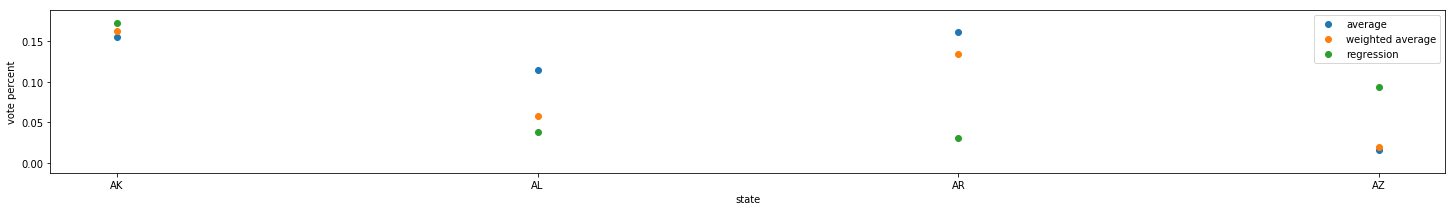

In [24]:
plt.figure(figsize=(25,3))
ax = plt.axes()
ax.scatter(states[0:4], dem_avg_err[0:4])
ax.scatter(states[0:4], dem_w_avg_err[0:4])
ax.scatter(states[0:4], dem_regr_err[0:4])

ax.legend(['average', 'weighted average', 'regression'])

ax.set_xlabel('state')
ax.set_ylabel('vote percent')

ax.axis('tight')

plt.show()

In [17]:
print(np.average(rep_w_avg_err))

0.08624924487489148


In [20]:
print(dem_averages)
print(dem_weighted_averages)
print(dem_regressions)
print(rep_averages)
print(rep_weighted_averages)
print(rep_regressions)
print(true_dems)
print(true_reps)

[0.36282623 0.4739443  0.53799236 0.41622479 0.53960746 0.46717887
 0.54869228 0.52298998 0.49212095 0.52486792 0.67071795 0.46553199
 0.36187137 0.54864871 0.43467741 0.3641779  0.49651554 0.56480517
 0.66705415 0.59013141 0.48721478 0.53722336 0.39495909 0.48721713
 0.438022   0.49149368 0.48793356 0.51247417 0.42044075 0.44413217
 0.53120203 0.48615627 0.49004854 0.60130515 0.49206905 0.43458343
 0.53856727 0.4987774  0.61312769 0.46728922 0.4589952  0.48236822
 0.4574665  0.35250228 0.44965907 0.4160627  0.54869065 0.53096208
 0.60055854 0.3567495 ]
[0.3693354  0.41714693 0.51070412 0.41140669 0.56429933 0.48243135
 0.5776388  0.53703508 0.48355378 0.47366109 0.6738116  0.46189566
 0.3437528  0.56382711 0.42759807 0.34908638 0.45819272 0.50188922
 0.68873481 0.60224356 0.50462539 0.54596471 0.35854917 0.48211085
 0.40535027 0.48105909 0.47997651 0.50445517 0.41875496 0.45660994
 0.54092639 0.50758061 0.48202376 0.62558018 0.48657977 0.39096843
 0.55584362 0.50641838 0.63569678 0.43